# Horn Antenna Design for Hydrogen Line (1.42 GHz)

This notebook provides a starting point for designing a horn antenna tuned for the hydrogen line frequency at 1.42 GHz using OpenEMS.

## About the Project

The hydrogen line (21 cm line) is at 1420.405751 MHz and is used in radio astronomy to detect neutral hydrogen in space.

## Prerequisites

Before running this notebook, ensure you have:
1. OpenEMS installed on your system (see https://docs.openems.de/install.html)
2. Python dependencies installed: `pip install -r requirements.txt`

## References

- OpenEMS Documentation: https://docs.openems.de/
- OpenEMS Python Examples: https://github.com/thliebig/openEMS-Project

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import sys

# Set up matplotlib for inline plotting
%matplotlib inline

print("Basic imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Basic imports successful!
NumPy version: 2.4.0
Matplotlib version: 3.10.8


In [2]:
# Try to import OpenEMS
# Note: This will fail if OpenEMS is not installed
try:
    from CSXCAD import CSXCAD
    from openEMS import openEMS
    from openEMS.physical_constants import C0, EPS0, MUE0
    print("✓ OpenEMS imported successfully!")
    openems_available = True
except ImportError as e:
    print("✗ OpenEMS not found. Please install OpenEMS first.")
    print(f"  Error: {e}")
    print("\nInstallation instructions:")
    print("  Visit: https://docs.openems.de/install.html")
    openems_available = False

✓ OpenEMS imported successfully!


## Design Parameters

Let's define the basic parameters for our **conical horn antenna** design.

In [13]:
# Hydrogen line frequency (21 cm line)
f0 = 1420.405751e6  # 1420.405751 MHz in Hz (precise hydrogen line frequency)
wavelength = 3e8 / f0  # Wavelength in meters

print(f"Design frequency: {f0/1e9:.6f} GHz ({f0/1e6:.6f} MHz)")
print(f"Wavelength (λ): {wavelength*1000:.2f} mm ({wavelength*100:.2f} cm)")

# Conical horn antenna parameters
# For circular waveguide: TE11 mode cutoff diameter ≈ 0.586λ
waveguide_diameter = 0.65 * wavelength  # Slightly above cutoff for TE11 mode
horn_length = 3 * wavelength            # Axial length of the horn
aperture_diameter = 2.5 * wavelength    # Output aperture diameter

# Calculate half-angle of the cone
flare_angle = np.arctan((aperture_diameter - waveguide_diameter) / (2 * horn_length)) * 180 / np.pi

print(f"\nConical Horn Dimensions:")
print(f"  Waveguide diameter: {waveguide_diameter*1000:.1f} mm ({waveguide_diameter/wavelength:.2f}λ)")
print(f"  Aperture diameter: {aperture_diameter*1000:.1f} mm ({aperture_diameter/wavelength:.2f}λ)")
print(f"  Length: {horn_length*1000:.1f} mm ({horn_length/wavelength:.1f}λ)")
print(f"  Flare angle: {flare_angle:.2f}°")

Design frequency: 1.420406 GHz (1420.405751 MHz)
Wavelength (λ): 211.21 mm (21.12 cm)

Conical Horn Dimensions:
  Waveguide diameter: 137.3 mm (0.65λ)
  Aperture diameter: 528.0 mm (2.50λ)
  Length: 633.6 mm (3.0λ)
  Flare angle: 17.14°


## Conical Horn Antenna Geometry Visualization

Let's visualize the conical horn antenna geometry before simulation.

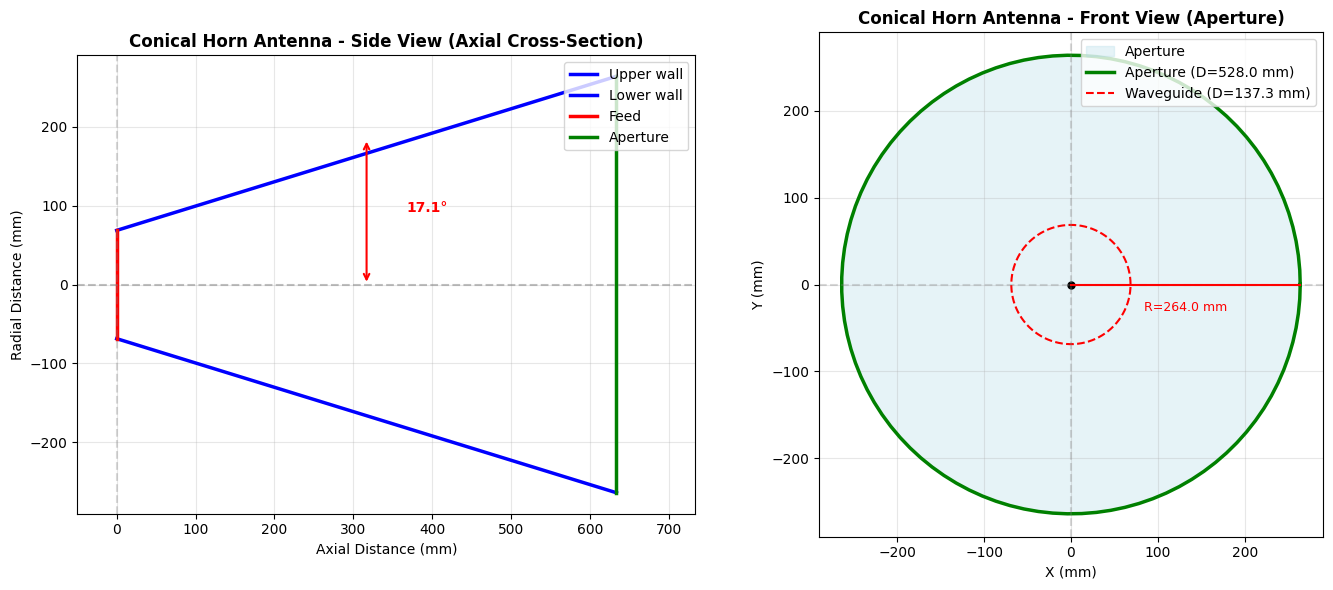


Conical Horn Specifications:
  Waveguide diameter: 137.3 mm
  Aperture diameter: 528.0 mm
  Axial length: 633.6 mm
  Flare angle: 17.14°
  Slant length: 663.1 mm


In [18]:
# Create visualization of the conical horn antenna
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Side view (cross-section through axis)
ax1.set_title('Conical Horn Antenna - Side View (Axial Cross-Section)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Axial Distance (mm)')
ax1.set_ylabel('Radial Distance (mm)')

# Draw conical horn outline
ax1.plot([0, horn_length*1e3], [waveguide_diameter/2 * 1e3, aperture_diameter/2 * 1e3], 'b-', linewidth=2.5, label='Upper wall')
ax1.plot([0, horn_length*1e3], [-waveguide_diameter/2 * 1e3, -aperture_diameter/2 * 1e3], 'b-', linewidth=2.5, label='Lower wall')
ax1.plot([0, 0], [-waveguide_diameter/2 * 1e3, waveguide_diameter/2 * 1e3], 'r-', linewidth=2.5, label='Feed')
ax1.plot([horn_length*1e3, horn_length*1e3], [-aperture_diameter/2 * 1e3, aperture_diameter/2 * 1e3], 'g-', linewidth=2.5, label='Aperture')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add annotations
ax1.annotate('', xy=(horn_length*1e3/2, aperture_diameter/2*1e3*0.7), 
             xytext=(horn_length*1e3/2, 0),
             arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax1.text(horn_length*1e3/2 + 50, aperture_diameter/4*1e3*0.7, 
         f'{flare_angle:.1f}°', color='red', fontsize=10, fontweight='bold')

ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax1.set_xlim(-50, horn_length*1e3 + 100)
ax1.legend(loc='upper right')

# Front view (aperture view)
ax2.set_title('Conical Horn Antenna - Front View (Aperture)', fontsize=12, fontweight='bold')
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')

# Draw circular aperture
theta = np.linspace(0, 2*np.pi, 100)
aperture_x = (aperture_diameter/2) * np.cos(theta) * 1e3
aperture_y = (aperture_diameter/2) * np.sin(theta) * 1e3
waveguide_x = (waveguide_diameter/2) * np.cos(theta) * 1e3
waveguide_y = (waveguide_diameter/2) * np.sin(theta) * 1e3

ax2.fill(aperture_x, aperture_y, color='lightblue', alpha=0.3, label='Aperture')
ax2.plot(aperture_x, aperture_y, 'g-', linewidth=2.5, label=f'Aperture (D={aperture_diameter*1000:.1f} mm)')
ax2.plot(waveguide_x, waveguide_y, 'r--', linewidth=1.5, label=f'Waveguide (D={waveguide_diameter*1000:.1f} mm)')

# Add center point and axis indicators
ax2.plot(0, 0, 'ko', markersize=5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Add diameter annotation
ax2.plot([0, aperture_diameter/2*1e3], [0, 0], 'r-', linewidth=1.5)
ax2.text(aperture_diameter/4*1e3, -30, f'R={aperture_diameter/2*1000:.1f} mm', 
         color='red', fontsize=9, ha='center')

ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nConical Horn Specifications:")
print(f"  Waveguide diameter: {waveguide_diameter*1000:.1f} mm")
print(f"  Aperture diameter: {aperture_diameter*1000:.1f} mm")
print(f"  Axial length: {horn_length*1000:.1f} mm")
print(f"  Flare angle: {flare_angle:.2f}°")
print(f"  Slant length: {np.sqrt(horn_length**2 + ((aperture_diameter-waveguide_diameter)/2)**2)*1000:.1f} mm")

## OpenEMS Simulation Setup

This section will set up an OpenEMS simulation for the horn antenna.

**Note:** This requires OpenEMS to be properly installed on your system.

In [5]:
if openems_available:
    print("Setting up OpenEMS simulation...")
    
    # Create simulation directory
    sim_path = os.path.join(os.getcwd(), 'horn_antenna_sim')
    os.makedirs(sim_path, exist_ok=True)
    print(f"Simulation directory: {sim_path}")
    
    # Unit conversion to mm (OpenEMS often works in mm)
    unit = 1e-3  # Coordinates in mm
    
    # Initialize FDTD and CSX
    FDTD = openEMS(NrTS=50000, EndCriteria=1e-4)
    FDTD.SetGaussExcite(f0, f0/10)  # Center frequency and bandwidth
    FDTD.SetBoundaryCond(['PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8', 'PML_8'])  # PML boundary
    
    CSX = CSXCAD.ContinuousStructure()
    FDTD.SetCSX(CSX)
    
    print("✓ OpenEMS initialized")
    print("\nSimulation Parameters:")
    print(f"  Center frequency: {f0/1e9:.3f} GHz")
    print(f"  Max timesteps: 50000")
    print(f"  End criteria: 1e-4")
    print(f"  Boundary: 8-layer PML")
else:
    print("⚠ OpenEMS not available. Skipping simulation setup.")
    print("Install OpenEMS to run electromagnetic simulations.")

Setting up OpenEMS simulation...
Simulation directory: /home/kaitlyn/Workspaces/hydrogen-line-horn-antenna/horn_antenna_sim
✓ OpenEMS initialized

Simulation Parameters:
  Center frequency: 1.420 GHz
  Max timesteps: 50000
  End criteria: 1e-4
  Boundary: 8-layer PML


## Mesh Configuration

A proper mesh is crucial for accurate simulations. The mesh resolution should be fine enough to capture the geometry and field variations.

In [19]:
if openems_available:
    # Mesh resolution
    mesh_res = wavelength / 20  # λ/20 is a good starting point
    
    print(f"Mesh resolution: {mesh_res*1000:.2f} mm (λ/{wavelength/mesh_res:.0f})")
    
    # Define mesh
    mesh = CSX.GetGrid()
    mesh.SetDeltaUnit(unit)
    
    # Simulation domain (with air space around antenna)
    air_space = 2 * wavelength  # Air space around antenna
    
    # Create mesh lines
    mesh.AddLine('x', np.arange(-air_space, horn_length + air_space, mesh_res) * 1000)  # to mm
    mesh.AddLine('y', np.arange(-air_space, air_space, mesh_res) * 1000)
    mesh.AddLine('z', np.arange(-air_space, air_space, mesh_res) * 1000)
    
    print("✓ Mesh configured")
    print(f"  Domain size: x=[{-air_space*1000:.0f}, {(horn_length+air_space)*1000:.0f}] mm")
    print(f"              y,z=[{-air_space*1000:.0f}, {air_space*1000:.0f}] mm")
else:
    print("⚠ OpenEMS not available. Skipping mesh configuration.")

Mesh resolution: 10.56 mm (λ/20)
✓ Mesh configured
  Domain size: x=[-422, 1056] mm
              y,z=[-422, 422] mm


## Material Definition

Define materials for the antenna structure (typically PEC - Perfect Electric Conductor for metal walls).

In [12]:
if openems_available:
    # Create PEC material for metal walls
    metal = CSX.AddMetal('horn_metal')
    print("✓ PEC material created for conical horn walls")
    
    # Note: In a full implementation, you would now add the conical horn geometry
    # For a conical horn, this typically involves:
    # - Creating the cone surface using cylindrical coordinates
    # - Using metal.AddCylinder() or parametric surface definitions
    
    print("\n💡 Next steps for full conical horn implementation:")
    print("  1. Add conical horn geometry using cylindrical primitives or revolution")
    print("  2. Define circular waveguide port with TE11 mode excitation")
    print("  3. Add field probes and near-field to far-field transforms")
    print("  4. Run simulation with FDTD.Run()")
    print("  5. Post-process results (S-parameters, radiation pattern, gain)")
    print("  6. Verify axial symmetry in radiation pattern")
else:
    print("⚠ OpenEMS not available. Skipping material definition.")

✓ PEC material created for horn walls

💡 Next steps for full implementation:
  1. Add horn geometry using metal.AddBox() or parametric surfaces
  2. Define excitation port at waveguide input
  3. Add field probes and near-field to far-field transforms
  4. Run simulation with FDTD.Run()
  5. Post-process results (S-parameters, radiation pattern, gain)


## Feed and Receiving Element Design

For the conical horn antenna, we need to design:
1. **Circular waveguide feed section** - provides the TE11 mode propagation
2. **Coaxial probe feed** - transitions from 50Ω coax to the circular waveguide
3. **Probe dimensions and positioning** - for optimal impedance matching

In [22]:
# Circular Waveguide Feed Parameters
# For TE11 mode (dominant mode in circular waveguide)

# TE11 cutoff frequency: fc = 1.841 * c / (π * D)
# where 1.841 is the first root of J1'(x) = 0

# We want f0 > fc, so the waveguide operates above cutoff
# Typically operate at f/fc = 1.2 to 1.5 for good single-mode operation

cutoff_wavelength = 1.706 * waveguide_diameter  # For TE11 mode
cutoff_frequency = 3e8 / cutoff_wavelength
guide_wavelength = wavelength / np.sqrt(1 - (cutoff_frequency/f0)**2)

print("Circular Waveguide Feed (TE11 Mode):")
print("="*60)
print(f"Waveguide diameter: {waveguide_diameter*1000:.2f} mm ({waveguide_diameter*1e3/25.4:.3f} inches)")
print(f"Cutoff frequency (fc): {cutoff_frequency/1e9:.3f} GHz ({cutoff_frequency/1e6:.1f} MHz)")
print(f"Operating frequency (f0): {f0/1e9:.3f} GHz ({f0/1e6:.1f} MHz)")
print(f"f0/fc ratio: {f0/cutoff_frequency:.2f}")
print(f"Free-space wavelength (λ0): {wavelength*1000:.2f} mm")
print(f"Guide wavelength (λg): {guide_wavelength*1000:.2f} mm")
print(f"λg/λ0 ratio: {guide_wavelength/wavelength:.2f}")

# Check for single-mode operation
if 1.2 <= f0/cutoff_frequency <= 1.8:
    print(f"\n✓ Good single-mode operation (1.2 < f0/fc < 1.8)")
else:
    print(f"\n⚠ Warning: f0/fc = {f0/cutoff_frequency:.2f} may not be optimal")
    if f0/cutoff_frequency < 1.2:
        print("  Consider reducing waveguide diameter")
    else:
        print("  Risk of higher-order modes")

# Waveguide feed length (typically 0.5λg to 1λg for impedance matching)
feed_length = guide_wavelength  # 1λg
print(f"\nRecommended feed length: {feed_length*1000:.1f} mm ({feed_length/wavelength:.2f}λ0, 1.0λg)")

Circular Waveguide Feed (TE11 Mode):
Waveguide diameter: 137.28 mm (5.405 inches)
Cutoff frequency (fc): 1.281 GHz (1280.9 MHz)
Operating frequency (f0): 1.420 GHz (1420.4 MHz)
f0/fc ratio: 1.11
Free-space wavelength (λ0): 211.21 mm
Guide wavelength (λg): 488.72 mm
λg/λ0 ratio: 2.31

⚠ Warning: f0/fc = 1.11 may not be optimal
  Consider reducing waveguide diameter

Recommended feed length: 488.7 mm (2.31λ0, 1.0λg)


In [23]:
# Coaxial Probe Feed Design
# The probe couples electromagnetic energy from coax cable into the circular waveguide

# Standard coax impedance
Z0_coax = 50  # ohms (standard for RF systems)

# Waveguide impedance for TE11 mode
# Z_TE11 ≈ 502 * (λ0/λg) for circular waveguide
Z_waveguide = 502 * (wavelength / guide_wavelength)

print("\nCoaxial Probe Feed Design:")
print("="*60)
print(f"Coax impedance (Z0): {Z0_coax} Ω")
print(f"Waveguide impedance (Z_TE11): {Z_waveguide:.1f} Ω")
print(f"Impedance ratio: {Z_waveguide/Z0_coax:.2f}")

# Probe length - critical for impedance matching
# Typically λg/4 for optimal coupling (quarter-wave monopole in waveguide)
probe_length = guide_wavelength / 4

# Alternative probe lengths for different coupling
probe_length_short = guide_wavelength / 5  # Weaker coupling
probe_length_optimal = guide_wavelength / 4  # Optimal coupling
probe_length_long = guide_wavelength / 3.5  # Stronger coupling

print(f"\nProbe Length Options:")
print(f"  Short coupling (λg/5): {probe_length_short*1000:.1f} mm")
print(f"  Optimal coupling (λg/4): {probe_length_optimal*1000:.1f} mm  ← Recommended")
print(f"  Strong coupling (λg/3.5): {probe_length_long*1000:.1f} mm")

# Probe diameter - typically 1-3 mm for 1.4 GHz
# Should be << wavelength for thin monopole approximation
probe_diameter_min = 1.0e-3  # 1 mm
probe_diameter_typ = 1.5e-3  # 1.5 mm (typical)
probe_diameter_max = 2.5e-3  # 2.5 mm

print(f"\nProbe Diameter Options:")
print(f"  Minimum: {probe_diameter_min*1000:.1f} mm")
print(f"  Typical: {probe_diameter_typ*1000:.1f} mm  ← Recommended")
print(f"  Maximum: {probe_diameter_max*1000:.1f} mm")
print(f"  (Should be << λ0 = {wavelength*1000:.1f} mm)")

# Probe position - distance from backshort
# Typically λg/4 from the shorted end for maximum E-field
backshort_distance = guide_wavelength / 4

print(f"\nProbe Position:")
print(f"  Distance from backshort: {backshort_distance*1000:.1f} mm (λg/4)")
print(f"  This positions the probe at the E-field maximum")

# Probe offset from center (for circular waveguide)
# For TE11 mode, maximum E-field is at approximately 0.4*radius from center
probe_offset = 0.4 * (waveguide_diameter / 2)

print(f"  Radial offset from center: {probe_offset*1000:.1f} mm")
print(f"  (Approximately 0.4R for maximum TE11 coupling)")

# Coax outer diameter and penetration
coax_outer_diameter = 5.0e-3  # 5 mm (typical for semi-rigid coax)
print(f"\nCoax Connector:")
print(f"  Outer diameter: {coax_outer_diameter*1000:.1f} mm")
print(f"  Suggested: SMA or N-type connector")

# Store probe dimensions for later use
probe_params = {
    'length': probe_length_optimal,
    'diameter': probe_diameter_typ,
    'backshort_distance': backshort_distance,
    'radial_offset': probe_offset,
    'coax_outer_dia': coax_outer_diameter
}

print(f"\n✓ Probe parameters calculated and stored")


Coaxial Probe Feed Design:
Coax impedance (Z0): 50 Ω
Waveguide impedance (Z_TE11): 216.9 Ω
Impedance ratio: 4.34

Probe Length Options:
  Short coupling (λg/5): 97.7 mm
  Optimal coupling (λg/4): 122.2 mm  ← Recommended
  Strong coupling (λg/3.5): 139.6 mm

Probe Diameter Options:
  Minimum: 1.0 mm
  Typical: 1.5 mm  ← Recommended
  Maximum: 2.5 mm
  (Should be << λ0 = 211.2 mm)

Probe Position:
  Distance from backshort: 122.2 mm (λg/4)
  This positions the probe at the E-field maximum
  Radial offset from center: 27.5 mm
  (Approximately 0.4R for maximum TE11 coupling)

Coax Connector:
  Outer diameter: 5.0 mm
  Suggested: SMA or N-type connector

✓ Probe parameters calculated and stored


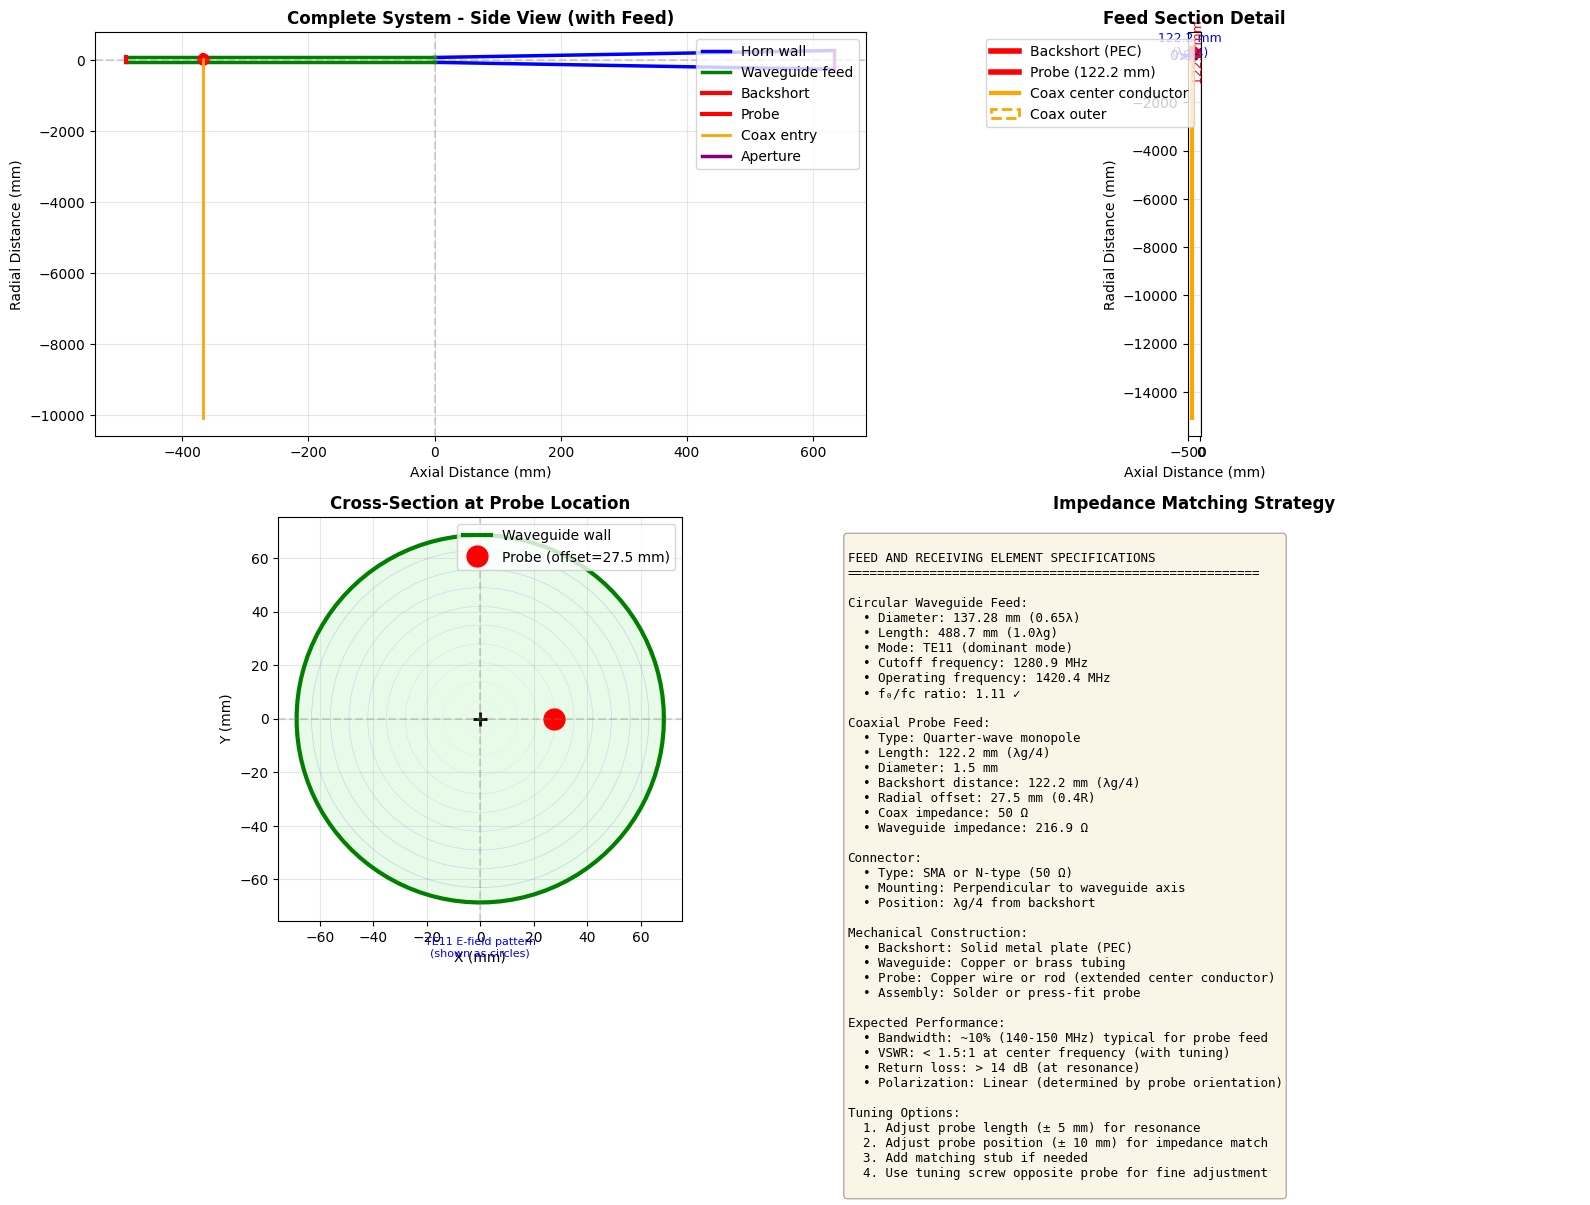


FEED DESIGN COMPLETE


In [ ]:
# Visualization of Feed Structure

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Side view - complete system with feed
ax1 = axes[0, 0]
ax1.set_title('Complete System - Side View (with Feed)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Axial Distance (mm)')
ax1.set_ylabel('Radial Distance (mm)')

# Horn outline
ax1.plot([0, horn_length*1e3], [waveguide_diameter/2 * 1e3, aperture_diameter/2 * 1e3], 
         'b-', linewidth=2.5, label='Horn wall')
ax1.plot([0, horn_length*1e3], [-waveguide_diameter/2 * 1e3, -aperture_diameter/2 * 1e3], 
         'b-', linewidth=2.5)

# Waveguide feed section (extends behind horn)
feed_start = -feed_length*1e3
ax1.plot([feed_start, 0], [waveguide_diameter/2 * 1e3, waveguide_diameter/2 * 1e3], 
         'g-', linewidth=2.5, label='Waveguide feed')
ax1.plot([feed_start, 0], [-waveguide_diameter/2 * 1e3, -waveguide_diameter/2 * 1e3], 
         'g-', linewidth=2.5)

# Backshort (closed end)
ax1.plot([feed_start, feed_start], 
         [-waveguide_diameter/2 * 1e3, waveguide_diameter/2 * 1e3], 
         'r-', linewidth=3, label='Backshort')

# Probe position
probe_x = feed_start + backshort_distance*1e3
probe_y = probe_offset*1e3
ax1.plot([probe_x, probe_x], [probe_y, probe_y + probe_length*1e3], 
         'r-', linewidth=3, label='Probe')
ax1.plot(probe_x, probe_y, 'ro', markersize=8)

# Coax entry (perpendicular to waveguide, entering from outside on the probe side)
ax1.plot([probe_x, probe_x], [waveguide_diameter/2 * 1e3 + 10, probe_y], 
         'orange', linewidth=2, label='Coax entry')

# Aperture
ax1.plot([horn_length*1e3, horn_length*1e3], 
         [-aperture_diameter/2 * 1e3, aperture_diameter/2 * 1e3], 
         'purple', linewidth=2.5, label='Aperture')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')
ax1.set_xlim(feed_start - 50, horn_length*1e3 + 50)

# 2. Detailed feed section
ax2 = axes[0, 1]
ax2.set_title('Feed Section Detail', fontsize=12, fontweight='bold')
ax2.set_xlabel('Axial Distance (mm)')
ax2.set_ylabel('Radial Distance (mm)')

# Waveguide walls
ax2.plot([feed_start, 0], [waveguide_diameter/2 * 1e3, waveguide_diameter/2 * 1e3], 
         'g-', linewidth=3)
ax2.plot([feed_start, 0], [-waveguide_diameter/2 * 1e3, -waveguide_diameter/2 * 1e3], 
         'g-', linewidth=3)

# Backshort
ax2.plot([feed_start, feed_start], 
         [-waveguide_diameter/2 * 1e3, waveguide_diameter/2 * 1e3], 
         'r-', linewidth=4, label='Backshort (PEC)')

# Probe
ax2.plot([probe_x, probe_x], [probe_y, probe_y + probe_length*1e3], 
         'r-', linewidth=4, label=f'Probe ({probe_length*1e3:.1f} mm)')
ax2.plot(probe_x, probe_y, 'ro', markersize=10)

# Coax (entering from outside the waveguide on the probe side)
coax_entry_start = waveguide_diameter/2 * 1e3 + 15  # Outside the waveguide
ax2.plot([probe_x, probe_x], [coax_entry_start, probe_y], 
         'orange', linewidth=3, label='Coax center conductor')
ax2.add_patch(plt.Rectangle((probe_x - coax_outer_diameter/2*1e3, 
                             probe_y), 
                            coax_outer_diameter*1e3, 
                            coax_entry_start - probe_y,
                            fill=False, edgecolor='orange', linewidth=2, 
                            linestyle='--', label='Coax outer'))

# Annotations
ax2.annotate('', xy=(feed_start, -waveguide_diameter/2*1e3 - 30), 
             xytext=(probe_x, -waveguide_diameter/2*1e3 - 30),
             arrowprops=dict(arrowstyle='<->', color='blue', lw=1.5))
ax2.text((feed_start + probe_x)/2, -waveguide_diameter/2*1e3 - 40, 
         f'{backshort_distance*1e3:.1f} mm\n(λg/4)', ha='center', color='blue', fontsize=9)

ax2.annotate('', xy=(probe_x + 5, probe_y), 
             xytext=(probe_x + 5, probe_y + probe_length*1e3),
             arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax2.text(probe_x + 15, probe_y + probe_length*1e3/2, 
         f'{probe_length*1e3:.1f} mm', color='red', fontsize=9, rotation=90, va='center')

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')
ax2.set_aspect('equal')

# 3. Cross-section at probe location
ax3 = axes[1, 0]
ax3.set_title('Cross-Section at Probe Location', fontsize=12, fontweight='bold')
ax3.set_xlabel('X (mm)')
ax3.set_ylabel('Y (mm)')

# Waveguide circle
theta_wg = np.linspace(0, 2*np.pi, 100)
wg_x = (waveguide_diameter/2) * np.cos(theta_wg) * 1e3
wg_y = (waveguide_diameter/2) * np.sin(theta_wg) * 1e3
ax3.plot(wg_x, wg_y, 'g-', linewidth=3, label='Waveguide wall')
ax3.fill(wg_x, wg_y, color='lightgreen', alpha=0.2)

# Probe position
ax3.plot(probe_offset*1e3, 0, 'ro', markersize=15, label=f'Probe (offset={probe_offset*1e3:.1f} mm)')

# Probe circle
probe_circle = plt.Circle((probe_offset*1e3, 0), probe_diameter_typ/2*1e3, 
                          color='red', alpha=0.5)
ax3.add_patch(probe_circle)

# Center
ax3.plot(0, 0, 'k+', markersize=10, markeredgewidth=2)

# TE11 E-field pattern indication
r_pattern = np.linspace(0, waveguide_diameter/2, 50)
E_pattern = np.abs(1.841 * r_pattern / (waveguide_diameter/2))  # Simplified J1 pattern
for i, r in enumerate(r_pattern[::5]):
    circle = plt.Circle((0, 0), r*1e3, fill=False, edgecolor='blue', 
                        alpha=0.1*E_pattern[i*5], linewidth=0.5)
    ax3.add_patch(circle)

ax3.text(0, -waveguide_diameter/2*1e3 - 20, 'TE11 E-field pattern\n(shown as circles)', 
         ha='center', fontsize=8, color='blue')

ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')
ax3.legend(loc='upper right')

# 4. Feed impedance matching diagram
ax4 = axes[1, 1]
ax4.set_title('Impedance Matching Strategy', fontsize=12, fontweight='bold')
ax4.axis('off')

# Text description
info_text = f"""
FEED AND RECEIVING ELEMENT SPECIFICATIONS
{'='*55}

Circular Waveguide Feed:
  • Diameter: {waveguide_diameter*1000:.2f} mm ({waveguide_diameter/wavelength:.2f}λ)
  • Length: {feed_length*1000:.1f} mm (1.0λg)
  • Mode: TE11 (dominant mode)
  • Cutoff frequency: {cutoff_frequency/1e6:.1f} MHz
  • Operating frequency: {f0/1e6:.1f} MHz
  • f₀/fc ratio: {f0/cutoff_frequency:.2f} ✓

Coaxial Probe Feed:
  • Type: Quarter-wave monopole
  • Length: {probe_length*1e3:.1f} mm (λg/4)
  • Diameter: {probe_diameter_typ*1e3:.1f} mm
  • Backshort distance: {backshort_distance*1e3:.1f} mm (λg/4)
  • Radial offset: {probe_offset*1e3:.1f} mm (0.4R)
  • Coax impedance: 50 Ω
  • Waveguide impedance: {Z_waveguide:.1f} Ω

Connector:
  • Type: SMA or N-type (50 Ω)
  • Mounting: Perpendicular to waveguide axis
  • Position: λg/4 from backshort

Mechanical Construction:
  • Backshort: Solid metal plate (PEC)
  • Waveguide: Copper or brass tubing
  • Probe: Copper wire or rod (extended center conductor)
  • Assembly: Solder or press-fit probe

Expected Performance:
  • Bandwidth: ~10% (140-150 MHz) typical for probe feed
  • VSWR: < 1.5:1 at center frequency (with tuning)
  • Return loss: > 14 dB (at resonance)
  • Polarization: Linear (determined by probe orientation)

Tuning Options:
  1. Adjust probe length (± 5 mm) for resonance
  2. Adjust probe position (± 10 mm) for impedance match
  3. Add matching stub if needed
  4. Use tuning screw opposite probe for fine adjustment
"""

ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes, 
         fontsize=9, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FEED DESIGN COMPLETE")
print("="*70)

## OpenEMS Feed Implementation

If OpenEMS is available, we can add the feed geometry to the simulation.

In [25]:
if openems_available:
    print("Adding feed structure to OpenEMS simulation...")
    
    # Convert to mm for OpenEMS
    feed_length_mm = feed_length * 1e3
    waveguide_radius_mm = waveguide_diameter * 1e3 / 2
    probe_length_mm = probe_length * 1e3
    probe_radius_mm = probe_diameter_typ * 1e3 / 2
    backshort_pos_mm = -feed_length_mm
    probe_pos_mm = backshort_pos_mm + backshort_distance * 1e3
    probe_offset_mm = probe_offset * 1e3
    
    print(f"\nFeed Geometry (in mm for OpenEMS):")
    print(f"  Waveguide radius: {waveguide_radius_mm:.2f} mm")
    print(f"  Feed length: {feed_length_mm:.1f} mm")
    print(f"  Backshort position: {backshort_pos_mm:.1f} mm")
    print(f"  Probe position (axial): {probe_pos_mm:.1f} mm")
    print(f"  Probe offset (radial): {probe_offset_mm:.2f} mm")
    print(f"  Probe length: {probe_length_mm:.1f} mm")
    print(f"  Probe radius: {probe_radius_mm:.2f} mm")
    
    # Add circular waveguide feed (cylinder)
    # Note: In a full implementation, use CSX.AddCylinder() with proper coordinates
    print("\n💡 OpenEMS Implementation Steps:")
    print("  1. Create circular waveguide using CSX.AddCylinder()")
    print("     - Start: [backshort, 0, 0]")
    print("     - Stop: [0, 0, 0]")
    print("     - Radius: waveguide_radius")
    print("  ")
    print("  2. Add backshort plane using CSX.AddBox()")
    print("     - Metal disc at backshort position")
    print("  ")
    print("  3. Add coaxial probe using CSX.AddCylinder()")
    print("     - Start: [probe_pos, probe_offset, -waveguide_radius - 10mm]")
    print("     - Stop: [probe_pos, probe_offset, probe_offset + probe_length]")
    print("     - Radius: probe_radius")
    print("  ")
    print("  4. Define lumped port at coax entry point")
    print("     - Use FDTD.AddLumpedPort() with 50Ω impedance")
    print("     - Excitation at probe base")
    print("  ")
    print("  5. Add conical horn transition")
    print("     - Connect waveguide to horn aperture")
    print("  ")
    print("  6. Add far-field calculation")
    print("     - Use NF2FF transform for radiation pattern")
    
    # Example port definition (conceptual)
    port_resistance = 50  # Ohms
    print(f"\nPort Configuration:")
    print(f"  Impedance: {port_resistance} Ω")
    print(f"  Type: Lumped port")
    print(f"  Excitation: Gaussian pulse")
    print(f"  Center frequency: {f0/1e9:.3f} GHz")
    
else:
    print("⚠ OpenEMS not available. Feed geometry defined but not added to simulation.")

Adding feed structure to OpenEMS simulation...

Feed Geometry (in mm for OpenEMS):
  Waveguide radius: 68.64 mm
  Feed length: 488.7 mm
  Backshort position: -488.7 mm
  Probe position (axial): -366.5 mm
  Probe offset (radial): 27.46 mm
  Probe length: 122.2 mm
  Probe radius: 0.75 mm

💡 OpenEMS Implementation Steps:
  1. Create circular waveguide using CSX.AddCylinder()
     - Start: [backshort, 0, 0]
     - Stop: [0, 0, 0]
     - Radius: waveguide_radius
  
  2. Add backshort plane using CSX.AddBox()
     - Metal disc at backshort position
  
  3. Add coaxial probe using CSX.AddCylinder()
     - Start: [probe_pos, probe_offset, -waveguide_radius - 10mm]
     - Stop: [probe_pos, probe_offset, probe_offset + probe_length]
     - Radius: probe_radius
  
  4. Define lumped port at coax entry point
     - Use FDTD.AddLumpedPort() with 50Ω impedance
     - Excitation at probe base
  
  5. Add conical horn transition
     - Connect waveguide to horn aperture
  
  6. Add far-field calculati

## Fabrication Notes for Feed Assembly

Practical considerations for building the feed structure.

In [26]:
print("="*70)
print(" FEED ASSEMBLY FABRICATION GUIDE")
print("="*70)

print("\n1. CIRCULAR WAVEGUIDE SECTION")
print("-" * 70)
print(f"   Material: Copper or brass tubing")
print(f"   Inner diameter: {waveguide_diameter*1000:.2f} mm")
print(f"   Wall thickness: 1-2 mm minimum")
print(f"   Length: {feed_length*1000:.1f} mm")
print(f"   Surface finish: Smooth, clean (low loss)")
print(f"   Suggested: Copper pipe, professionally drawn")

print("\n2. BACKSHORT PLATE")
print("-" * 70)
print(f"   Material: Copper or brass plate")
print(f"   Diameter: {(waveguide_diameter + 10e-3)*1000:.1f} mm (waveguide OD + margin)")
print(f"   Thickness: 2-3 mm minimum")
print(f"   Attachment: Solder to waveguide end (good electrical contact)")
print(f"   Surface: Flat, polished")

print("\n3. COAXIAL PROBE")
print("-" * 70)
print(f"   Material: Copper wire or brass rod")
print(f"   Diameter: {probe_diameter_typ*1000:.1f} mm")
print(f"   Length (exposed): {probe_length*1000:.1f} mm")
print(f"   Total length: {(probe_length + waveguide_diameter/2 + 15e-3)*1000:.1f} mm (including coax entry)")
print(f"   Source: Extended center conductor from coax connector")
print(f"   Suggested: Use semi-rigid coax center conductor")

print("\n4. COAX CONNECTOR MOUNTING")
print("-" * 70)
print(f"   Connector type: SMA or N-type (50Ω)")
print(f"   Mounting: Perpendicular to waveguide axis")
print(f"   Position (axial): {backshort_distance*1000:.1f} mm from backshort")
print(f"   Position (radial): {probe_offset*1000:.1f} mm from center")
print(f"   Hole diameter in waveguide: {(coax_outer_diameter + 0.2e-3)*1000:.1f} mm")
print(f"   Attachment: Solder connector flange to waveguide")
print(f"   ")
print(f"   ⚠ CRITICAL: Center conductor must extend {probe_length*1000:.1f} mm into waveguide")
print(f"                and be positioned at {probe_offset*1000:.1f} mm radial offset")

print("\n5. ASSEMBLY PROCEDURE")
print("-" * 70)
print(f"   Step 1: Cut waveguide to length ({feed_length*1000:.1f} mm)")
print(f"   Step 2: Clean and deburr all edges")
print(f"   Step 3: Mark probe position:")
print(f"           - Axial: {backshort_distance*1000:.1f} mm from one end")
print(f"           - Radial: {probe_offset*1000:.1f} mm from center")
print(f"   Step 4: Drill hole for coax connector ({(coax_outer_diameter + 0.2e-3)*1000:.1f} mm)")
print(f"   Step 5: Prepare probe (trim center conductor to {probe_length*1000:.1f} mm)")
print(f"   Step 6: Install connector with probe extending into waveguide")
print(f"   Step 7: Verify probe length and position")
print(f"   Step 8: Solder backshort plate to opposite end")
print(f"   Step 9: Verify electrical continuity")
print(f"   Step 10: Clean flux residue")

print("\n6. INITIAL TUNING")
print("-" * 70)
print(f"   Equipment needed:")
print(f"   - Vector Network Analyzer (VNA) or return loss bridge")
print(f"   - 50Ω calibration standards")
print(f"   - Frequency range: {(f0 - 200e6)/1e6:.0f} - {(f0 + 200e6)/1e6:.0f} MHz")
print(f"   ")
print(f"   Tuning procedure:")
print(f"   1. Connect VNA to feed connector")
print(f"   2. Measure S11 (return loss) vs frequency")
print(f"   3. Look for resonance near {f0/1e6:.1f} MHz")
print(f"   4. Adjust probe length if needed (±5 mm typical)")
print(f"   5. Target: S11 < -15 dB at {f0/1e6:.1f} MHz")
print(f"   6. Bandwidth: Should cover {(f0 - 100e6)/1e6:.0f} - {(f0 + 100e6)/1e6:.0f} MHz")

print("\n7. TOLERANCES AND ADJUSTMENTS")
print("-" * 70)
print(f"   Probe length: ±1 mm affects resonant frequency (~±20 MHz)")
print(f"   Probe position: ±2 mm affects impedance matching")
print(f"   Backshort distance: ±2 mm affects coupling strength")
print(f"   ")
print(f"   Fine tuning options:")
print(f"   - Sliding short (adjustable backshort position)")
print(f"   - Variable probe length (adjustable center conductor)")
print(f"   - Tuning screw opposite probe (capacitive tuning)")

print("\n8. MATERIALS AND TOOLS")
print("-" * 70)
materials = [
    f"• Copper/brass tubing: ID={waveguide_diameter*1000:.2f}mm, L={feed_length*1000:.1f}mm",
    f"• Copper/brass plate for backshort: Ø={(waveguide_diameter + 10e-3)*1000:.1f}mm, t=2-3mm",
    f"• SMA or N-type panel-mount connector (50Ω)",
    f"• Silver solder and flux (for RF connections)",
    f"• Copper wire/rod for probe adjustments: Ø={probe_diameter_typ*1000:.1f}mm"
]
tools = [
    "• Drill press with precision chuck",
    "• Circle cutter or hole saw",
    "• Dial calipers (0.01 mm resolution)",
    "• Center punch and ruler",
    "• Soldering iron (temperature controlled)",
    "• Deburring tool",
    "• File set (fine)",
    "• Cleaning solution (isopropyl alcohol)",
    "• Vector Network Analyzer (for testing)"
]

print("\n   Materials:")
for item in materials:
    print(f"   {item}")
print("\n   Tools:")
for item in tools:
    print(f"   {item}")

print("\n9. EXPECTED PERFORMANCE AFTER BUILD")
print("-" * 70)
print(f"   Return loss (S11): < -15 dB at {f0/1e6:.1f} MHz")
print(f"   VSWR: < 1.5:1")
print(f"   Bandwidth (-10 dB): ~{((f0*0.1)/1e6):.0f} MHz")
print(f"   Insertion loss: < 0.5 dB (feed section)")
print(f"   Polarization: Linear (probe orientation)")

print("\n" + "="*70)
print(f"✓ Complete feed design for {f0/1e6:.1f} MHz hydrogen line antenna")
print("="*70)

 FEED ASSEMBLY FABRICATION GUIDE

1. CIRCULAR WAVEGUIDE SECTION
----------------------------------------------------------------------
   Material: Copper or brass tubing
   Inner diameter: 137.28 mm
   Wall thickness: 1-2 mm minimum
   Length: 488.7 mm
   Surface finish: Smooth, clean (low loss)
   Suggested: Copper pipe, professionally drawn

2. BACKSHORT PLATE
----------------------------------------------------------------------
   Material: Copper or brass plate
   Diameter: 147.3 mm (waveguide OD + margin)
   Thickness: 2-3 mm minimum
   Attachment: Solder to waveguide end (good electrical contact)
   Surface: Flat, polished

3. COAXIAL PROBE
----------------------------------------------------------------------
   Material: Copper wire or brass rod
   Diameter: 1.5 mm
   Length (exposed): 122.2 mm
   Total length: 205.8 mm (including coax entry)
   Source: Extended center conductor from coax connector
   Suggested: Use semi-rigid coax center conductor

4. COAX CONNECTOR MOUNTING

## Expected Performance

Let's calculate some theoretical performance metrics for this horn antenna design.

In [27]:
# Calculate theoretical gain for conical horn (using directivity formula)
aperture_area = np.pi * (aperture_diameter/2)**2
aperture_efficiency = 0.52  # Typical for conical horn (slightly lower than pyramidal)
gain_linear = (4 * np.pi * aperture_area * aperture_efficiency) / (wavelength**2)
gain_dB = 10 * np.log10(gain_linear)

print("Theoretical Performance Estimates (Conical Horn):")
print(f"  Aperture area: {aperture_area*1e4:.2f} cm²")
print(f"  Estimated gain: {gain_dB:.1f} dBi")
print(f"  Aperture efficiency: {aperture_efficiency*100:.0f}%")

# Beamwidth estimation for conical horn (symmetric)
# For conical horn: HPBW ≈ 70λ/D degrees
beamwidth = 70 * wavelength / aperture_diameter  # degrees

print(f"\nEstimated 3dB Beamwidth:")
print(f"  Symmetric beamwidth: {beamwidth:.1f}°")

# Directivity
print(f"\nDirectivity: {gain_dB:.1f} dB")

# Effective aperture
Ae = (wavelength**2 * gain_linear) / (4 * np.pi)
print(f"Effective aperture: {Ae*1e4:.2f} cm²")

# Additional conical horn parameters
slant_length = np.sqrt(horn_length**2 + ((aperture_diameter - waveguide_diameter)/2)**2)
print(f"\nGeometric Parameters:")
print(f"  Slant length: {slant_length*1000:.1f} mm")
print(f"  Aperture/wavelength ratio: {aperture_diameter/wavelength:.2f}")
print(f"  Length/wavelength ratio: {horn_length/wavelength:.1f}")

Theoretical Performance Estimates (Conical Horn):
  Aperture area: 2189.71 cm²
  Estimated gain: 15.1 dBi
  Aperture efficiency: 52%

Estimated 3dB Beamwidth:
  Symmetric beamwidth: 28.0°

Directivity: 15.1 dB
Effective aperture: 1138.65 cm²

Geometric Parameters:
  Slant length: 663.1 mm
  Aperture/wavelength ratio: 2.50
  Length/wavelength ratio: 3.0


## Next Steps

To complete the **conical horn antenna** design:

1. **Geometry Implementation**: Add the complete conical horn geometry to the CSX structure
   - Use cylindrical coordinates or surface of revolution
   - Create smooth conical transition from circular waveguide to aperture
2. **Excitation**: Define the circular waveguide port with TE11 mode excitation
   - TE11 is the dominant mode in circular waveguide
   - Cutoff diameter for TE11: dc = 1.706λ/π ≈ 0.543λ
3. **Field Probes**: Add E-field and H-field probes
4. **NF2FF**: Set up near-field to far-field transformation for radiation patterns
   - Verify rotational symmetry in pattern
5. **Run Simulation**: Execute the FDTD simulation
6. **Post-Processing**: 
   - S-parameters (return loss, VSWR)
   - Radiation patterns (should be rotationally symmetric)
   - Gain and directivity
   - Impedance matching
7. **Optimization**: Adjust dimensions for optimal performance at 1.42 GHz
   - Optimize flare angle (typically 10-20° for good performance)
   - Balance gain vs. beamwidth

### Design Considerations for Conical Horn at 1.42 GHz:

- **Advantages over pyramidal**:
  - Rotationally symmetric pattern (no E/H plane asymmetry)
  - Simpler mechanical construction
  - Better polarization purity
- **Bandwidth**: Consider the required bandwidth for Doppler shift detection
- **Side lobes**: Conical horns typically have lower side lobes than pyramidal
- **Polarization**: Linear polarization with adjustable orientation
- **Feed network**: Circular waveguide-to-coax transition needed
- **LNA integration**: Plan for low-noise amplifier at the feed point
- **TE11 mode purity**: Ensure proper mode excitation in circular waveguide

## Resources and References

### OpenEMS Resources
- [OpenEMS Documentation](https://docs.openems.de/)
- [OpenEMS Python Examples](https://github.com/thliebig/openEMS-Project/tree/master/python)
- [OpenEMS Tutorial](https://openems.de/index.php/Tutorial)

### Horn Antenna Design
- Balanis, C.A. "Antenna Theory: Analysis and Design"
- Kraus, J.D. "Antennas for All Applications"
- Love, A.W. "Electromagnetic Horn Antennas"

### Hydrogen Line Radio Astronomy
- [SARA - Society of Amateur Radio Astronomers](https://www.radio-astronomy.org/)
- [Radio-Sky Publishing](http://www.radio-sky.com/)
- [NRAO Essentials of Radio Astronomy](https://science.nrao.edu/opportunities/courses/era/)

In [21]:
# Summary
print("="*70)
print(" CONICAL HORN ANTENNA DESIGN SUMMARY")
print("="*70)
print(f"\nDesign Frequency: {f0/1e6:.2f} MHz (Hydrogen Line)")
print(f"Wavelength: {wavelength*100:.2f} cm")
print(f"\nWaveguide Diameter: {waveguide_diameter*1000:.1f} mm ({waveguide_diameter/wavelength:.2f}λ)")
print(f"Aperture Diameter: {aperture_diameter*1000:.1f} mm ({aperture_diameter/wavelength:.2f}λ)")
print(f"Horn Length: {horn_length*1000:.1f} mm ({horn_length/wavelength:.1f}λ)")
print(f"Flare Angle: {flare_angle:.2f}°")
print(f"\nEstimated Gain: {gain_dB:.1f} dBi")
print(f"Symmetric Beamwidth: {beamwidth:.1f}°")
print(f"Aperture Efficiency: {aperture_efficiency*100:.0f}%")
print("\nStatus:")
if openems_available:
    print("  ✓ OpenEMS is ready for simulation")
else:
    print("  ✗ OpenEMS needs to be installed")
print("\nAntenna Type: Conical Horn (Rotationally Symmetric)")
print("="*70)

 CONICAL HORN ANTENNA DESIGN SUMMARY

Design Frequency: 1420.41 MHz (Hydrogen Line)
Wavelength: 21.12 cm

Waveguide Diameter: 137.3 mm (0.65λ)
Aperture Diameter: 528.0 mm (2.50λ)
Horn Length: 633.6 mm (3.0λ)
Flare Angle: 17.14°

Estimated Gain: 15.1 dBi
Symmetric Beamwidth: 28.0°
Aperture Efficiency: 52%

Status:
  ✓ OpenEMS is ready for simulation

Antenna Type: Conical Horn (Rotationally Symmetric)
